# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

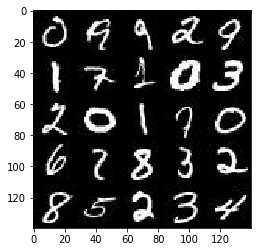

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

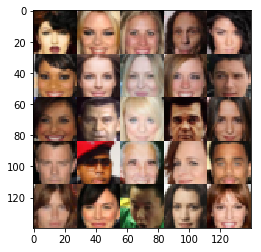

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='real_input')
    input_z = tf.placeholder(tf.float32, [None, z_dim], name='generator_input')
    
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return input_real, input_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        leaky_relu_alpha = 0.02

        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        conv1_relu = tf.maximum(conv1, conv1 * leaky_relu_alpha)
        
        conv2 = tf.layers.conv2d(conv1_relu, 128, 5, strides=2, padding='same')
        conv2_batch_normal = tf.layers.batch_normalization(conv2, training=True)
        conv2_relu = tf.maximum(conv2_batch_normal, conv2_batch_normal * leaky_relu_alpha)
        
        conv3 = tf.layers.conv2d(conv2_relu, 256, 5, strides=2, padding='same')
        conv3_batch_normal = tf.layers.batch_normalization(conv3, training=True)
        conv3_relu = tf.maximum(conv3_batch_normal, conv3_batch_normal * leaky_relu_alpha)
        
        conv3_flat = tf.reshape(conv3_relu, (-1, 4*4*256))
        
        logits = tf.layers.dense(conv3_flat, 1)
        output = tf.sigmoid(logits)

    return output, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        leaky_relu_alpha = 0.02
        
        fc = tf.layers.dense(z, 7*7*512)
        
        fc = tf.reshape(fc, (-1, 7, 7, 512))
        fc_batch_normal = tf.layers.batch_normalization(fc, training=is_train)
        fc_relu = tf.maximum(fc_batch_normal, fc_batch_normal * leaky_relu_alpha)
        
        deconv1 = tf.layers.conv2d_transpose(fc_relu, 128, 5, strides=1, padding='same')
        deconv1_batch_normal = tf.layers.batch_normalization(deconv1, training=is_train)
        deconv1_relu = tf.maximum(deconv1_batch_normal, deconv1_batch_normal * leaky_relu_alpha)
        
        deconv2 = tf.layers.conv2d_transpose(deconv1_relu, 64, 5, strides=2, padding='same')
        deconv2_batch_normal = tf.layers.batch_normalization(deconv2, training=is_train)
        deconv2_relu = tf.maximum(deconv2_batch_normal, deconv2_batch_normal * leaky_relu_alpha)

        logits = tf.layers.conv2d_transpose(deconv2_relu, out_channel_dim, 5, strides=2, padding='same')
        
        output = tf.tanh(logits)
    return output

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    gen_out = generator(input_z, out_channel_dim)
    
    disc_out_real, disc_logit_real = discriminator(input_real)
    disc_out_fake, disc_logit_fake = discriminator(gen_out, reuse=True)
    
    disc_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logit_real,
                                                                            labels = tf.ones_like(disc_out_real) * 0.9))
    
    disc_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logit_fake,
                                                                            labels = tf.zeros_like(disc_out_fake)))
    
    disc_loss = disc_loss_real + disc_loss_fake
    
    gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logit_fake,
                                                                      labels=tf.ones_like(disc_out_fake)))
    
    return disc_loss, gen_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    train_vars = tf.trainable_variables()
    
    gen_vars = [var for var in train_vars if var.name.startswith('generator')]
    disc_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    
    gen_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=gen_vars)
    disc_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=disc_vars)
    
    return disc_opt, gen_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """  
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    
    input_real, input_z, _ = model_inputs(image_width, image_height, image_channels, z_dim)    
    
    disc_loss, gen_loss = model_loss(input_real, input_z, image_channels)    
    disc_opt, gen_opt = model_opt(disc_loss, gen_loss, learning_rate, beta1)
    
    steps = 0
    
    print_output_interval = 20
    show_output_interval = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps = steps + 1
                
                batch_images = batch_images * 2.0
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(disc_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(gen_opt, feed_dict={input_z: batch_z})
                
                if steps % print_output_interval == 0:
                    gen_train_loss = gen_loss.eval({input_z: batch_z})
                    disc_train_loss = disc_loss.eval({input_real: batch_images, input_z: batch_z})
                    
                    print("Epoch => {}/{} ".format(epoch_i + 1, epoch_count),
                          "Discriminator Loss: {:.3f}".format(disc_train_loss),
                          "Generator Loss: {:.3f}".format(gen_train_loss))
                
                if steps % show_output_interval == 0:
                    print ("\nPlot Number > {}".format(steps // show_output_interval))
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch => 1/2  Discriminator Loss: 3.843 Generator Loss: 6.855
Epoch => 1/2  Discriminator Loss: 0.418 Generator Loss: 3.240
Epoch => 1/2  Discriminator Loss: 0.713 Generator Loss: 3.532
Epoch => 1/2  Discriminator Loss: 3.890 Generator Loss: 0.076
Epoch => 1/2  Discriminator Loss: 1.486 Generator Loss: 1.961

Plot Number > 1


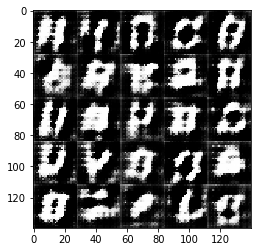

Epoch => 1/2  Discriminator Loss: 1.185 Generator Loss: 1.450
Epoch => 1/2  Discriminator Loss: 1.186 Generator Loss: 0.620
Epoch => 1/2  Discriminator Loss: 0.817 Generator Loss: 1.165
Epoch => 1/2  Discriminator Loss: 1.684 Generator Loss: 0.376
Epoch => 1/2  Discriminator Loss: 1.239 Generator Loss: 0.993

Plot Number > 2


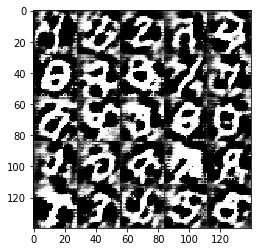

Epoch => 1/2  Discriminator Loss: 1.215 Generator Loss: 0.767
Epoch => 1/2  Discriminator Loss: 1.301 Generator Loss: 0.672
Epoch => 1/2  Discriminator Loss: 1.113 Generator Loss: 1.103
Epoch => 1/2  Discriminator Loss: 1.725 Generator Loss: 0.365
Epoch => 1/2  Discriminator Loss: 1.353 Generator Loss: 0.550

Plot Number > 3


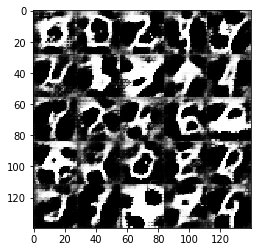

Epoch => 1/2  Discriminator Loss: 1.233 Generator Loss: 1.686
Epoch => 1/2  Discriminator Loss: 1.646 Generator Loss: 0.384
Epoch => 1/2  Discriminator Loss: 1.178 Generator Loss: 1.674
Epoch => 1/2  Discriminator Loss: 2.161 Generator Loss: 2.278
Epoch => 1/2  Discriminator Loss: 1.361 Generator Loss: 0.564

Plot Number > 4


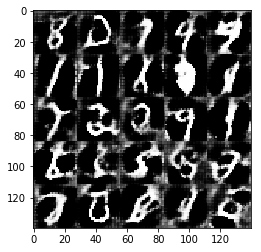

Epoch => 1/2  Discriminator Loss: 0.728 Generator Loss: 1.817
Epoch => 1/2  Discriminator Loss: 1.089 Generator Loss: 0.909
Epoch => 1/2  Discriminator Loss: 1.107 Generator Loss: 1.411
Epoch => 2/2  Discriminator Loss: 0.718 Generator Loss: 2.522
Epoch => 2/2  Discriminator Loss: 1.209 Generator Loss: 0.879

Plot Number > 5


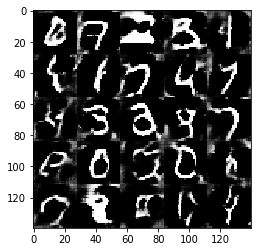

Epoch => 2/2  Discriminator Loss: 1.261 Generator Loss: 0.648
Epoch => 2/2  Discriminator Loss: 1.068 Generator Loss: 1.585
Epoch => 2/2  Discriminator Loss: 0.977 Generator Loss: 1.598
Epoch => 2/2  Discriminator Loss: 1.540 Generator Loss: 0.515
Epoch => 2/2  Discriminator Loss: 1.276 Generator Loss: 1.192

Plot Number > 6


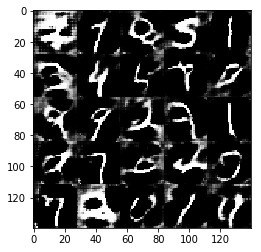

Epoch => 2/2  Discriminator Loss: 1.202 Generator Loss: 1.117
Epoch => 2/2  Discriminator Loss: 1.544 Generator Loss: 0.478
Epoch => 2/2  Discriminator Loss: 1.414 Generator Loss: 0.582
Epoch => 2/2  Discriminator Loss: 1.071 Generator Loss: 1.109
Epoch => 2/2  Discriminator Loss: 1.154 Generator Loss: 0.882

Plot Number > 7


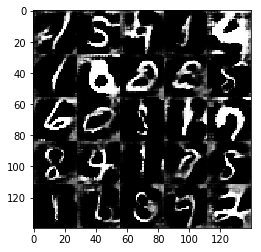

Epoch => 2/2  Discriminator Loss: 1.062 Generator Loss: 1.452
Epoch => 2/2  Discriminator Loss: 1.160 Generator Loss: 0.942
Epoch => 2/2  Discriminator Loss: 1.144 Generator Loss: 1.280
Epoch => 2/2  Discriminator Loss: 1.150 Generator Loss: 0.911
Epoch => 2/2  Discriminator Loss: 1.689 Generator Loss: 0.437

Plot Number > 8


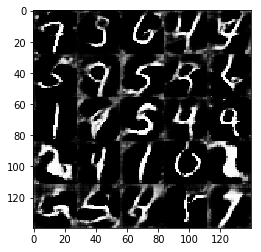

Epoch => 2/2  Discriminator Loss: 1.508 Generator Loss: 0.493
Epoch => 2/2  Discriminator Loss: 1.201 Generator Loss: 0.672
Epoch => 2/2  Discriminator Loss: 1.208 Generator Loss: 0.717
Epoch => 2/2  Discriminator Loss: 1.338 Generator Loss: 0.714
Epoch => 2/2  Discriminator Loss: 1.246 Generator Loss: 0.896

Plot Number > 9


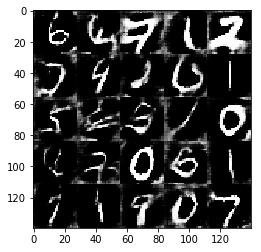

Epoch => 2/2  Discriminator Loss: 1.211 Generator Loss: 0.828


In [12]:
batch_size = 128
z_dim = 100
learning_rate = 0.004
beta1 = 0.25


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch => 1/1  Discriminator Loss: 0.523 Generator Loss: 3.897
Epoch => 1/1  Discriminator Loss: 0.458 Generator Loss: 4.464
Epoch => 1/1  Discriminator Loss: 0.572 Generator Loss: 3.619
Epoch => 1/1  Discriminator Loss: 0.746 Generator Loss: 1.710
Epoch => 1/1  Discriminator Loss: 1.057 Generator Loss: 0.907

Plot Number > 1


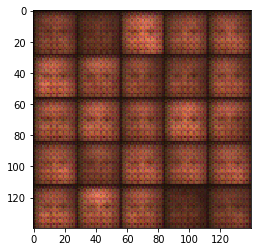

Epoch => 1/1  Discriminator Loss: 0.580 Generator Loss: 2.349
Epoch => 1/1  Discriminator Loss: 0.851 Generator Loss: 2.307
Epoch => 1/1  Discriminator Loss: 0.777 Generator Loss: 1.448
Epoch => 1/1  Discriminator Loss: 0.782 Generator Loss: 1.558
Epoch => 1/1  Discriminator Loss: 0.884 Generator Loss: 1.120

Plot Number > 2


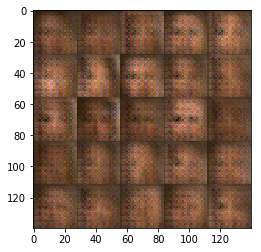

Epoch => 1/1  Discriminator Loss: 0.814 Generator Loss: 1.683
Epoch => 1/1  Discriminator Loss: 0.928 Generator Loss: 2.372
Epoch => 1/1  Discriminator Loss: 0.870 Generator Loss: 1.162
Epoch => 1/1  Discriminator Loss: 0.749 Generator Loss: 2.763
Epoch => 1/1  Discriminator Loss: 0.786 Generator Loss: 2.029

Plot Number > 3


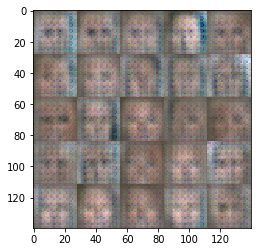

Epoch => 1/1  Discriminator Loss: 1.155 Generator Loss: 0.773
Epoch => 1/1  Discriminator Loss: 1.046 Generator Loss: 2.319
Epoch => 1/1  Discriminator Loss: 0.973 Generator Loss: 1.709
Epoch => 1/1  Discriminator Loss: 1.007 Generator Loss: 1.042
Epoch => 1/1  Discriminator Loss: 1.033 Generator Loss: 0.944

Plot Number > 4


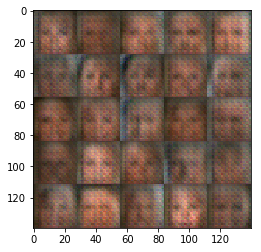

Epoch => 1/1  Discriminator Loss: 1.108 Generator Loss: 0.838
Epoch => 1/1  Discriminator Loss: 0.876 Generator Loss: 1.465
Epoch => 1/1  Discriminator Loss: 1.137 Generator Loss: 1.011
Epoch => 1/1  Discriminator Loss: 1.562 Generator Loss: 0.444
Epoch => 1/1  Discriminator Loss: 1.156 Generator Loss: 0.910

Plot Number > 5


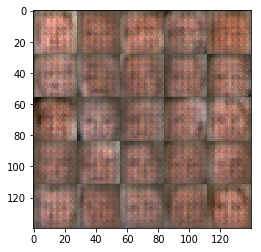

Epoch => 1/1  Discriminator Loss: 1.114 Generator Loss: 1.771
Epoch => 1/1  Discriminator Loss: 1.039 Generator Loss: 0.959
Epoch => 1/1  Discriminator Loss: 0.921 Generator Loss: 1.396
Epoch => 1/1  Discriminator Loss: 0.987 Generator Loss: 1.241
Epoch => 1/1  Discriminator Loss: 1.285 Generator Loss: 2.093

Plot Number > 6


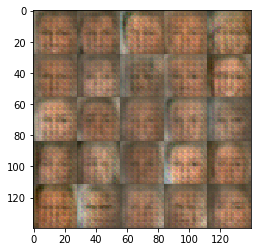

Epoch => 1/1  Discriminator Loss: 0.995 Generator Loss: 1.363
Epoch => 1/1  Discriminator Loss: 1.109 Generator Loss: 0.883
Epoch => 1/1  Discriminator Loss: 1.260 Generator Loss: 0.754
Epoch => 1/1  Discriminator Loss: 1.200 Generator Loss: 0.744
Epoch => 1/1  Discriminator Loss: 1.018 Generator Loss: 1.005

Plot Number > 7


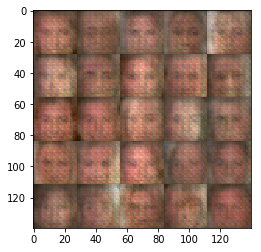

Epoch => 1/1  Discriminator Loss: 1.141 Generator Loss: 1.042
Epoch => 1/1  Discriminator Loss: 1.158 Generator Loss: 0.737
Epoch => 1/1  Discriminator Loss: 0.955 Generator Loss: 1.307
Epoch => 1/1  Discriminator Loss: 1.370 Generator Loss: 0.559
Epoch => 1/1  Discriminator Loss: 1.279 Generator Loss: 0.758

Plot Number > 8


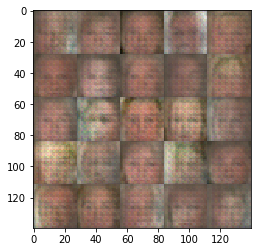

Epoch => 1/1  Discriminator Loss: 1.028 Generator Loss: 1.609
Epoch => 1/1  Discriminator Loss: 1.018 Generator Loss: 1.002
Epoch => 1/1  Discriminator Loss: 1.021 Generator Loss: 1.124
Epoch => 1/1  Discriminator Loss: 1.049 Generator Loss: 1.170
Epoch => 1/1  Discriminator Loss: 1.329 Generator Loss: 0.561

Plot Number > 9


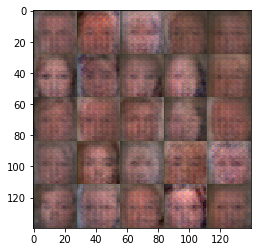

Epoch => 1/1  Discriminator Loss: 0.976 Generator Loss: 1.199
Epoch => 1/1  Discriminator Loss: 0.973 Generator Loss: 1.097
Epoch => 1/1  Discriminator Loss: 0.835 Generator Loss: 1.376
Epoch => 1/1  Discriminator Loss: 1.345 Generator Loss: 0.573
Epoch => 1/1  Discriminator Loss: 0.965 Generator Loss: 1.030

Plot Number > 10


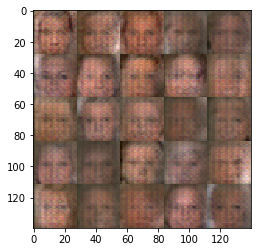

Epoch => 1/1  Discriminator Loss: 1.161 Generator Loss: 0.775
Epoch => 1/1  Discriminator Loss: 1.275 Generator Loss: 1.618
Epoch => 1/1  Discriminator Loss: 1.032 Generator Loss: 1.003
Epoch => 1/1  Discriminator Loss: 1.127 Generator Loss: 0.742
Epoch => 1/1  Discriminator Loss: 1.318 Generator Loss: 0.588

Plot Number > 11


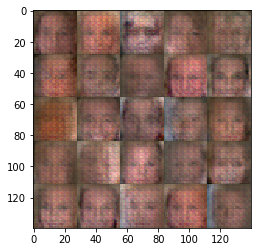

Epoch => 1/1  Discriminator Loss: 1.118 Generator Loss: 1.264
Epoch => 1/1  Discriminator Loss: 1.148 Generator Loss: 0.787
Epoch => 1/1  Discriminator Loss: 1.099 Generator Loss: 1.393
Epoch => 1/1  Discriminator Loss: 1.213 Generator Loss: 0.702
Epoch => 1/1  Discriminator Loss: 1.280 Generator Loss: 0.631

Plot Number > 12


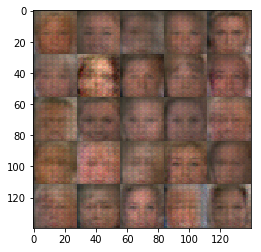

Epoch => 1/1  Discriminator Loss: 1.075 Generator Loss: 1.707
Epoch => 1/1  Discriminator Loss: 1.019 Generator Loss: 1.048
Epoch => 1/1  Discriminator Loss: 1.169 Generator Loss: 0.790
Epoch => 1/1  Discriminator Loss: 1.049 Generator Loss: 1.187
Epoch => 1/1  Discriminator Loss: 1.211 Generator Loss: 0.674

Plot Number > 13


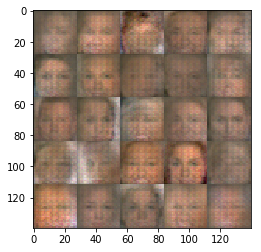

Epoch => 1/1  Discriminator Loss: 1.225 Generator Loss: 0.673
Epoch => 1/1  Discriminator Loss: 1.022 Generator Loss: 1.447
Epoch => 1/1  Discriminator Loss: 1.220 Generator Loss: 0.652
Epoch => 1/1  Discriminator Loss: 1.209 Generator Loss: 1.267
Epoch => 1/1  Discriminator Loss: 1.078 Generator Loss: 1.339

Plot Number > 14


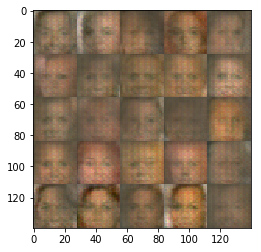

Epoch => 1/1  Discriminator Loss: 1.304 Generator Loss: 0.586
Epoch => 1/1  Discriminator Loss: 0.956 Generator Loss: 1.222
Epoch => 1/1  Discriminator Loss: 0.981 Generator Loss: 1.551
Epoch => 1/1  Discriminator Loss: 0.905 Generator Loss: 1.083
Epoch => 1/1  Discriminator Loss: 1.500 Generator Loss: 0.685

Plot Number > 15


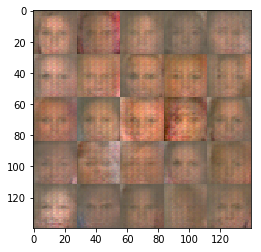

Epoch => 1/1  Discriminator Loss: 0.977 Generator Loss: 1.204
Epoch => 1/1  Discriminator Loss: 1.313 Generator Loss: 0.636
Epoch => 1/1  Discriminator Loss: 1.125 Generator Loss: 1.956
Epoch => 1/1  Discriminator Loss: 1.072 Generator Loss: 0.851


In [13]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.